New logic: Swire would want to predict the abandonment couple of days before the end of the window. 
Fit training data with cart abandonment but only up to the last 2 windows of puchase or abandon. 
Then for the test data, test/predict only couples days in not wait untill the end of the window. 

In [116]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


# from lightgbm import LGBMClassifier
# import xgboost as xgb
# from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns


# Clean google analytics.csv and join with customer.csv 


In [117]:
ga = pd.read_csv("Copy of google_analytics.csv")
pd.set_option('display.max_columns', None)
ga.head()

,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS
0,501508595,2025-04-07,2025-04-07T14:57:40.713Z,view_search_results,mobile,Samsung,Android,Product List,NaN,[]
1,501730915,2025-04-07,2025-04-07T19:28:54.546Z,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id..."
2,501567329,2025-04-07,2025-04-07T21:40:56.281Z,purchase,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,"[{""item_id"":""138335"",""quantity"":""2""},{""item_id..."
3,501765083,2025-04-08,2025-04-08T06:06:36.717Z,user_engagement,mobile,Apple,iOS,NaN,NaN,[]
4,501707837,2025-04-08,2025-04-08T18:12:10.511Z,view_item_list,desktop,Google,Windows,MyCoke Orders,Category: All Products,"[{""item_id"":""412588"",""quantity"":""1""},{""item_id..."


In [118]:
# Getting only cart affected events
ga_cart_events = ga[ga['EVENT_NAME'].isin(['add_to_cart', 'remove_from_cart','purchase'])]

In [119]:
# Join customer.csv with ga_cart_events to get customer's local time 
customer = pd.read_csv('Copy of customer.csv')

customer_ga_cart_events = pd.merge(ga_cart_events, customer, left_on='CUSTOMER_ID', right_on='CUSTOMER_NUMBER', how='left')

In [120]:
from zoneinfo import ZoneInfo
import pandas as pd

# ---- 1) City → timezone map (as you had) ----
city_tz = {
    "Tacoma, WA":"America/Los_Angeles","Spokane, WA":"America/Los_Angeles",
    "Arlington, WA":"America/Los_Angeles","Bellevue, WA":"America/Los_Angeles",
    "Walla Walla, WA":"America/Los_Angeles","Reno, NV":"America/Los_Angeles",
    "Elko, NV":"America/Los_Angeles","Pendleton, OR":"America/Los_Angeles",
    "Eugene, OR":"America/Los_Angeles","Wilsonville, OR":"America/Los_Angeles",
    "Bend, OR":"America/Los_Angeles","LaGrande, OR":"America/Los_Angeles",
    "Lewiston, ID":"America/Los_Angeles","Wenatchee, WA":"America/Los_Angeles",
    "Bremerton, WA":"America/Los_Angeles",
    "Denver, CO":"America/Denver","Colorado Springs, CO":"America/Denver",
    "Grand Junction, CO":"America/Denver","Glenwood Springs, CO":"America/Denver",
    "Pueblo, CO":"America/Denver","Alamosa, CO":"America/Denver",
    "Johnstown, CO":"America/Denver","Cheyenne, WY":"America/Denver",
    "Richfield, UT":"America/Denver","Draper, UT":"America/Denver",
    "Logan, UT":"America/Denver","Ogden, UT":"America/Denver",
    "Price, UT":"America/Denver","Albuquerque, NM":"America/Denver",
    "Scottsbluff, NE":"America/Denver",
    "Boise, ID":"America/Boise","Idaho Falls, ID":"America/Boise","Pocatello, ID":"America/Boise",
    "Tempe, AZ":"America/Phoenix","Tucson, AZ":"America/Phoenix",
    "Prescott, AZ":"America/Phoenix","Glendale, AZ":"America/Phoenix",
    "Kingman, AZ":"America/Phoenix","Huachuca City, AZ":"America/Phoenix",
    "Show Low, AZ":"America/Phoenix","Flagstaff, AZ":"America/Phoenix",
    "Yuma, AZ":"America/Phoenix",
}

# ---- 2) Parse timestamp as UTC (kept your column name) ----
customer_ga_cart_events["EVENT_TIMESTAMP_UTC"] = pd.to_datetime(
    customer_ga_cart_events["EVENT_TIMESTAMP"], utc=True, errors="coerce"
)

# ---- 3) Map timezone from CITY (use CITY consistently) ----
customer_ga_cart_events["TIMEZONE"] = customer_ga_cart_events["SALES_OFFICE_DESCRIPTION"].map(city_tz)

# ---- 4) Convert to local datetime per-row (only when TIMEZONE present) ----
customer_ga_cart_events["EVENT_LOCAL_DT"] = customer_ga_cart_events.apply(
    lambda row: (
        row["EVENT_TIMESTAMP_UTC"].astimezone(ZoneInfo(row["TIMEZONE"]))
        if pd.notna(row["TIMEZONE"]) and pd.notna(row["EVENT_TIMESTAMP_UTC"])
        else pd.NaT
    ),
    axis=1
)

# ---- 5) Convenience columns: date / hour / day-of-week ----
customer_ga_cart_events["EVENT_LOCAL_DATE"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.date() if pd.notna(v) else pd.NaT
)
customer_ga_cart_events["EVENT_LOCAL_TIME"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.strftime("%I:%M:%S %p") if pd.notna(v) else pd.NA
)
customer_ga_cart_events["EVENT_LOCAL_DOW"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.day_name() if pd.notna(v) else pd.NA
)

# ---- 6) Drop duplicates (use the actual UTC column name) ----
customer_ga_cart_events = customer_ga_cart_events.drop_duplicates(
    subset=["CUSTOMER_ID","EVENT_TIMESTAMP_UTC","EVENT_NAME"],
    keep="first"
)

# ---- 7) Select relevant columns (use consistent names) ----
cols = [
    "CUSTOMER_ID","CITY","TIMEZONE","EVENT_NAME",
    "EVENT_LOCAL_TIME","EVENT_LOCAL_DT","EVENT_LOCAL_DATE",
    "EVENT_LOCAL_HOUR","EVENT_LOCAL_DOW",
    "DEVICE_CATEGORY","DEVICE_MOBILE_BRAND_NAME","DEVICE_OPERATING_SYSTEM",
    "EVENT_PAGE_NAME","EVENT_PAGE_TITLE"
]
existing_cols = [c for c in cols if c in customer_ga_cart_events.columns]
customer_ga_cart_events = customer_ga_cart_events[existing_cols]

customer_ga_cart_events.head()


,CUSTOMER_ID,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE
0,501567329,America/Los_Angeles,purchase,02:40:56 PM,2025-04-07 14:40:56.281000-07:00,2025-04-07,Monday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order
1,501702910,America/Denver,add_to_cart,12:30:14 PM,2025-05-24 12:30:14.025000-06:00,2025-05-24,Saturday,desktop,Google,Windows,NaN,Search
2,501565777,America/Phoenix,add_to_cart,01:08:07 PM,2025-05-20 13:08:07.167000-07:00,2025-05-20,Tuesday,mobile,Samsung,Android,NaN,Search
3,501752380,America/Los_Angeles,add_to_cart,02:25:29 PM,2025-05-16 14:25:29.494000-07:00,2025-05-16,Friday,desktop,Apple,Macintosh,NaN,Search
4,500549947,America/Los_Angeles,add_to_cart,06:12:45 PM,2025-04-07 18:12:45.609000-07:00,2025-04-07,Monday,mobile,Apple,iOS,Product List,NaN


# The windows from master.csv

check between purchaes from order and purchase from GA, check how much missing is there. Finlay's table is already in windows format, can't use this because of new logic. 

In [121]:
windows = pd.read_csv('new_master.csv')

In [122]:
#Make name clear
windows['ORDER_CREATED_DATE_UTC'] = windows['CREATED_DATE_UTC']


#Drop leakage columns and column from GA adding later
windows = windows.drop(columns=['num_add_to_cart_events','total_items_added_to_cart',
                                'purchases','button_clicks','total_events','DISTRIBUTION_MODE',
                                'ABANDONED_CART','SALES_OFFICE_DESC','CREATED_DATE_EST','CREATED_DATE_UTC',
                                'ORDER_QUANTITY','ORDER_TYPE','MATERIAL_LIST'])



In [123]:
pd.set_option('display.max_columns', None)

windows.head(20)

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,ORDER_EXISTS,SHIPPING_CONDITIONS,ORDER_CREATED_DATE_UTC
0,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaN
1,500245685,2025-03-17,2025-03-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaN
2,500245685,2025-04-14,2025-04-21,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaN
3,500245685,2025-04-28,2025-05-05,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaN
4,500245738,2024-11-20,2024-11-27,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-11-22 18:46:16+00:00
5,500245738,2024-11-27,2024-12-04,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-11-28 02:46:16+00:00
6,500245738,2024-12-04,2024-12-11,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-12-04 22:02:03+00:00
7,500245738,2024-12-11,2024-12-18,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-12-13 01:44:02+00:00
8,500245738,2024-12-18,2024-12-25,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-12-23 22:36:08+00:00
9,500245738,2025-01-08,2025-01-15,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2025-01-08 19:21:06+00:00


# windows join customer_ga_cart_events

Join exploded windows to Google Analytics, with cart events only.

Left merge from windows and filter for correct dates of GA within windows. 

In [124]:
# Ensure datetime types
windows["ANCHOR_DATE"] = pd.to_datetime(windows["ANCHOR_DATE"])
windows["NEXT_ANCHOR_SAME_WD"] = pd.to_datetime(windows["NEXT_ANCHOR_SAME_WD"])
customer_ga_cart_events["EVENT_LOCAL_DATE"] = pd.to_datetime(customer_ga_cart_events["EVENT_LOCAL_DATE"])

# Perform a LEFT merge (windows = left table)
windows_with_ga = pd.merge(
    windows,
    customer_ga_cart_events,
    on="CUSTOMER_ID",
    how="left"
)


windows_with_ga["WINDOW_START_LOCAL"] = pd.to_datetime(
    windows_with_ga["ANCHOR_DATE"].dt.strftime("%Y-%m-%d") + " " + windows_with_ga['CUTOFFTIME__C'],   #CUTOFFTIME__C	?
    errors="coerce"
)
windows_with_ga["WINDOW_END_LOCAL"] = pd.to_datetime(
    windows_with_ga["NEXT_ANCHOR_SAME_WD"].dt.strftime("%Y-%m-%d") + " " + windows_with_ga['CUTOFFTIME__C'],
    errors="coerce"
)

# 2) Drop timezone from the event’s local datetime so it’s naive too
windows_with_ga["EVENT_LOCAL_NAIVE"] = windows_with_ga["EVENT_LOCAL_DT"].apply(
    lambda v: pd.NaT if pd.isna(v) else pd.Timestamp(v).tz_localize(None)
)

# 1) Build in-window mask (compare naive-to-naive)
in_window = (
    (windows_with_ga["EVENT_LOCAL_NAIVE"] >= windows_with_ga["WINDOW_START_LOCAL"]) &
    (windows_with_ga["EVENT_LOCAL_NAIVE"] <  windows_with_ga["WINDOW_END_LOCAL"])
)

# Turn ORDER_CREATED_DATE_UTC to local time 
windows_with_ga['ORDER_CREATED_DATE_UTC'] = pd.to_datetime(
    windows_with_ga['ORDER_CREATED_DATE_UTC'], utc=True, errors="coerce"
    ) 

windows_with_ga['ORDER_CREATED_DATE_LOCAL'] = windows_with_ga.apply(
    lambda row: (
        row["ORDER_CREATED_DATE_UTC"].astimezone(ZoneInfo(row["TIMEZONE"]))
        if pd.notna(row["TIMEZONE"]) and pd.notna(row["ORDER_CREATED_DATE_UTC"])
        else pd.NaT
    ),
    axis=1
)

windows_with_ga = windows_with_ga[in_window].copy()





/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_37372/2625391076.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  windows_with_ga["WINDOW_START_LOCAL"] = pd.to_datetime(
/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_37372/2625391076.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  windows_with_ga["WINDOW_END_LOCAL"] = pd.to_datetime(


This is all the GA cart events for each windows. Each windows migh have many events (unaggreagated)

In [125]:
windows_with_ga[windows_with_ga['CUSTOMER_ID']==501730915]

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,ORDER_EXISTS,SHIPPING_CONDITIONS,ORDER_CREATED_DATE_UTC,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,WINDOW_START_LOCAL,WINDOW_END_LOCAL,EVENT_LOCAL_NAIVE,ORDER_CREATED_DATE_LOCAL
1721073,501730915,2024-11-14,2024-11-21,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,add_to_cart,08:47:12 AM,2024-11-18 08:47:12.263000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,NaN,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:47:12.263,2024-11-18 09:01:15-07:00
1721075,501730915,2024-11-14,2024-11-21,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,add_to_cart,08:49:59 AM,2024-11-18 08:49:59.113000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:49:59.113,2024-11-18 09:01:15-07:00
1721079,501730915,2024-11-14,2024-11-21,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,add_to_cart,08:47:45 AM,2024-11-18 08:47:45.663000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,NaN,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:47:45.663,2024-11-18 09:01:15-07:00
1721087,501730915,2024-11-14,2024-11-21,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,add_to_cart,08:54:16 AM,2024-11-18 08:54:16.470000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:54:16.470,2024-11-18 09:01:15-07:00
1721097,501730915,2024-11-14,2024-11-21,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,purchase,08:56:09 AM,2024-11-18 08:56:09.930000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Order,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:56:09.930,2024-11-18 09:01:15-07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722798,501730915,2025-05-08,2025-05-15,G141,48 Hours,OFS,Thursday,7,3:00:00 PM,1,48,2025-05-12 20:10:56+00:00,America/Boise,purchase,02:00:11 PM,2025-05-12 14:00:11.669000-06:00,2025-05-12,Monday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,2025-05-08 15:00:00,2025-05-15 15:00:00,2025-05-12 14:00:11.669,2025-05-12 14:10:56-06:00
1722808,501730915,2025-05-08,2025-05-15,G141,48 Hours,OFS,Thursday,7,3:00:00 PM,1,48,2025-05-12 20:10:56+00:00,America/Boise,add_to_cart,01:59:19 PM,2025-05-12 13:59:19.895000-06:00,2025-05-12,Monday,desktop,Google,Windows,MyCoke Orders - Product:,Category: Energy Drinks,2025-05-08 15:00:00,2025-05-15 15:00:00,2025-05-12 13:59:19.895,2025-05-12 14:10:56-06:00
1722814,501730915,2025-05-08,2025-05-15,G141,48 Hours,OFS,Thursday,7,3:00:00 PM,1,48,2025-05-12 20:10:56+00:00,America/Boise,add_to_cart,01:58:44 PM,2025-05-12 13:58:44.112000-06:00,2025-05-12,Monday,desktop,Google,Windows,MyCoke Order Builder,Order Builder,2025-05-08 15:00:00,2025-05-15 15:00:00,2025-05-12 13:58:44.112,2025-05-12 14:10:56-06:00
1722908,501730915,2025-05-15,2025-05-22,G141,48 Hours,OFS,Thursday,7,3:00:00 PM,1,48,2025-05-20 03:10:17+00:00,America/Boise,add_to_cart,09:06:00 PM,2025-05-19 21:06:00.765000-06:00,2025-05-19,Monday,desktop,Google,Windows,MyCoke Order Builder,Order Builder,2025-05-15 15:00:00,2025-05-22 15:00:00,2025-05-19 21:06:00.765,2025-05-19 21:10:17-06:00


# New logic for GA cutoff date

Add a new cutoff date for the Predictive model, per each frequency

In [126]:
windows_with_ga1=windows_with_ga.copy()
# What are the top frequencies for customers
windows_with_ga1.groupby('WINDOW_FREQUENCY')['CUSTOMER_ID'].nunique()


WINDOW_FREQUENCY
7     1860
14     949
21      14
28    1372
Name: CUSTOMER_ID, dtype: int64

In [127]:
# Frequency cutoff change as needed
frequency_cutoff = {
    7:2,       
    14:4,
    21:7,
    28:10}

#New column
windows_with_ga1["event_cutoff_days"] = windows_with_ga1["WINDOW_FREQUENCY"].map(frequency_cutoff)


The problem, cutted off the purchase events by the days above. If we want to use cart activities - of todays, we need the target of tomorrows, not today. 

Change all WINDOW_END_LOCAL_event_cutoff = TRUE where EVENT_NAME = purchase. 

Then make 2 columns of purchase, purchase before and after event cutoff. 

If purchase before = True, delete row (already purchase, no need to predict)
If purchase after = TRUE then 0, not then 1. This will be the target variable

This way, if customer have cart activities before frequency cutoff and not yet purchase before it, then our model could predict if they are going to purchase or not. 

In the presentation, mention how much data we excluded because of our choice of event cutoff date. 

In [128]:
windows_with_ga1["WINDOW_END_LOCAL_event_cutoff"] = (
    windows_with_ga1["WINDOW_END_LOCAL"]
    - pd.to_timedelta(windows_with_ga1["event_cutoff_days"], unit="D") 
)


In [129]:
#Flag EVENT_LOCAL_NAIVE not within WINDOW_START_LOCAL - WINDOW_END_LOCAL_event_cutoff or EVENT_NAME == purchase
windows_with_ga1['event_within_new_cutoff_purchase'] = (
    (windows_with_ga1['EVENT_LOCAL_NAIVE'] <= windows_with_ga1['WINDOW_END_LOCAL_event_cutoff']) |
    (windows_with_ga1['EVENT_NAME'] == 'purchase')
)



In [130]:
# We have both purchase after and before event cutoff
windows_with_ga1[(windows_with_ga1['EVENT_NAME']=='purchase') & 
                 (windows_with_ga1['EVENT_LOCAL_NAIVE'] > windows_with_ga1['WINDOW_END_LOCAL_event_cutoff'])].head()

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,ORDER_EXISTS,SHIPPING_CONDITIONS,ORDER_CREATED_DATE_UTC,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,WINDOW_START_LOCAL,WINDOW_END_LOCAL,EVENT_LOCAL_NAIVE,ORDER_CREATED_DATE_LOCAL,event_cutoff_days,WINDOW_END_LOCAL_event_cutoff,event_within_new_cutoff_purchase
347,500245738,2024-11-27,2024-12-04,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-11-28 02:46:16+00:00,America/Denver,purchase,02:56:20 PM,2024-12-04 14:56:20.396000-07:00,2024-12-04,Wednesday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Checkout,2024-11-27 17:00:00,2024-12-04 17:00:00,2024-12-04 14:56:20.396,2024-11-27 19:46:16-07:00,2,2024-12-02 17:00:00,True
974,500245738,2025-01-15,2025-01-22,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2025-01-20 22:42:02+00:00,America/Denver,purchase,04:59:22 PM,2025-01-22 16:59:22.108000-07:00,2025-01-22,Wednesday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Checkout,2025-01-15 17:00:00,2025-01-22 17:00:00,2025-01-22 16:59:22.108,2025-01-20 15:42:02-07:00,2,2025-01-20 17:00:00,True
1221,500245738,2025-01-22,2025-01-29,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2025-01-23 00:04:07+00:00,America/Denver,purchase,02:59:08 PM,2025-01-29 14:59:08.187000-07:00,2025-01-29,Wednesday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Checkout,2025-01-22 17:00:00,2025-01-29 17:00:00,2025-01-29 14:59:08.187,2025-01-22 17:04:07-07:00,2,2025-01-27 17:00:00,True
1675,500245738,2025-02-12,2025-02-19,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2025-02-14 21:18:04+00:00,America/Denver,purchase,03:31:24 PM,2025-02-19 15:31:24.637000-07:00,2025-02-19,Wednesday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Checkout,2025-02-12 17:00:00,2025-02-19 17:00:00,2025-02-19 15:31:24.637,2025-02-14 14:18:04-07:00,2,2025-02-17 17:00:00,True
1894,500245738,2025-02-26,2025-03-05,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2025-03-03 21:42:19+00:00,America/Denver,purchase,04:59:21 PM,2025-03-05 16:59:21.361000-07:00,2025-03-05,Wednesday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Checkout,2025-02-26 17:00:00,2025-03-05 17:00:00,2025-03-05 16:59:21.361,2025-03-03 14:42:19-07:00,2,2025-03-03 17:00:00,True


In [131]:
# Which window have low leftover rate, so we could tweak the dict above
freq_cutoff_summary = (
    windows_with_ga1
    .groupby("WINDOW_FREQUENCY")["event_within_new_cutoff_purchase"]
    .mean()
    .sort_values(ascending=False)
)
print(freq_cutoff_summary)
print(f'Total len before cutoff for new logic {len(windows_with_ga1)}')


WINDOW_FREQUENCY
7     0.841351
21    0.780186
14    0.669780
28    0.603512
Name: event_within_new_cutoff_purchase, dtype: float64
Total len before cutoff for new logic 163360


In [132]:
#Get rows of data that the events are within the new cutoff date
windows_with_ga1 = windows_with_ga1[windows_with_ga1['event_within_new_cutoff_purchase']==True]
print(f'Total len after cutoff {len(windows_with_ga1)}')

Total len after cutoff 123648


# Aggregation

In [133]:
# Add events count before aggregations
windows_with_ga1["add_to_cart_count"] = (windows_with_ga1["EVENT_NAME"] == "add_to_cart").astype("int")
windows_with_ga1["remove_from_cart_count"] = (windows_with_ga1["EVENT_NAME"] == "remove_from_cart").astype("int")


windows_with_ga1["purchase_before_event_cutoff_count"] = ((windows_with_ga1['EVENT_NAME']=='purchase') & 
                                                                          (windows_with_ga1['EVENT_LOCAL_NAIVE'] <= windows_with_ga1['WINDOW_END_LOCAL_event_cutoff']))
windows_with_ga1["purchase_after_event_cutoff_count"] = ((windows_with_ga1['EVENT_NAME']=='purchase') & 
                                                                          (windows_with_ga1['EVENT_LOCAL_NAIVE'] > windows_with_ga1['WINDOW_END_LOCAL_event_cutoff']))


In [134]:
# How to agg EVENT_PAGE_TITLE?
with pd.option_context('display.max_rows', None):
    display(windows_with_ga1.groupby("EVENT_PAGE_TITLE").size())


EVENT_PAGE_TITLE
Cart                                                 12295
Category                                                91
Category: All Products                               25961
Category: CO2                                          751
Category: Coffee and Coffee Drinks                     463
Category: Cups / Lids                                  477
Category: Cups/Lids                                     15
Category: Cups/Lids/Straws                               8
Category: DP20oz                                         1
Category: Dairy                                       1445
Category: Energy Drinks                               3436
Category: Enhanced Water                              1170
Category: Flavors / Mixers / Sweeteners                405
Category: Flavors/Mixers/Sweeteners                     19
Category: Freestyle Products                           328
Category: Imports                                      353
Category: Juice and Juice Drinks       

In [135]:
# How to agg EVENT_PAGE_NAME
windows_with_ga1.groupby("EVENT_PAGE_NAME").size()


EVENT_PAGE_NAME
Cart Screen                                    2111
MyCoke Dashboard                               1077
MyCoke Invoices                                   6
MyCoke Order Builder                           2400
MyCoke Order History                              3
MyCoke Orders                                 35602
MyCoke Orders - Cart                          16248
MyCoke Orders - Product:                      12200
MyCoke Orders - Purchase Success              17926
MyCoke Product List - Category:                  83
MyCoke Support History - Customer Services       14
Product Details                                 347
Product List                                   4169
Public About MyCoke                               4
dtype: int64

In [136]:
windows_with_ga1.head(20)

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,ORDER_EXISTS,SHIPPING_CONDITIONS,ORDER_CREATED_DATE_UTC,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,WINDOW_START_LOCAL,WINDOW_END_LOCAL,EVENT_LOCAL_NAIVE,ORDER_CREATED_DATE_LOCAL,event_cutoff_days,WINDOW_END_LOCAL_event_cutoff,event_within_new_cutoff_purchase,add_to_cart_count,remove_from_cart_count,purchase_before_event_cutoff_count,purchase_after_event_cutoff_count
2,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:15:15 PM,2025-02-20 13:15:15.838000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:15:15.838,NaT,2,2025-02-22 17:00:00,True,0,1,False,False
3,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:09:26 PM,2025-02-20 13:09:26.094000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:09:26.094,NaT,2,2025-02-22 17:00:00,True,0,1,False,False
5,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:46:54 PM,2025-02-20 13:46:54.839000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:46:54.839,NaT,2,2025-02-22 17:00:00,True,0,1,False,False
9,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,purchase,02:15:17 PM,2025-02-20 14:15:17.604000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 14:15:17.604,NaT,2,2025-02-22 17:00:00,True,0,0,True,False
10,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:12:15 PM,2025-02-20 13:12:15.532000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:12:15.532,NaT,2,2025-02-22 17:00:00,True,0,1,False,False
11,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:09:45 PM,2025-02-20 13:09:45.050000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:09:45.050,NaT,2,2025-02-22 17:00:00,True,0,1,False,False
12,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,add_to_cart,01:08:17 PM,2025-02-20 13:08:17.399000-07:00,2025-02-20,Thursday,desktop,Google,Windows,NaN,Category: CO2,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:08:17.399,NaT,2,2025-02-22 17:00:00,True,1,0,False,False
15,500245685,2025-03-17,2025-03-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,add_to_cart,10:24:39 AM,2025-03-18 10:24:39.544000-06:00,2025-03-18,Tuesday,desktop,Google,Windows,MyCoke Orders - Product:,Product: 20#CYL X1 SH CO2 FULL#1,2025-03-17 17:00:00,2025-03-24 17:00:00,2025-03-18 10:24:39.544,NaT,2,2025-03-22 17:00:00,True,1,0,False,False
27,500245685,2025-03-17,2025-03-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,purchase,10:25:51 AM,2025-03-18 10:25:51.338000-06:00,2025-03-18,Tuesday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,2025-03-17 17:00:00,2025-03-24 17:00:00,2025-03-18 10:25:51.338,NaT,2,2025-03-22 17:00:00,True,0,0,True,False
32,500245685,2025-04-14,2025-04-21,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,02:10:55 PM,2025-04-17 14:10:55.514000-06:00,2025-04-17,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-04-14 17:00:00,2025-04-21 17:0

In [153]:
windows_with_ga2=windows_with_ga1.copy()

windows_with_ga2 = (
    windows_with_ga2
    .groupby(["CUSTOMER_ID","WINDOW_START_LOCAL","WINDOW_END_LOCAL","WINDOW_END_LOCAL_event_cutoff"], as_index=False)
    .agg(
        SALES_OFFICE=("SALES_OFFICE","first"),
        SHIPPING_CONDITIONS_DESC=("SHIPPING_CONDITIONS_DESC","first"),
        WEEK_DAY_OF_ANCHOR_DATE=("WEEK_DAY_OF_ANCHOR_DATE","first"),
        WINDOW_FREQUENCY=("WINDOW_FREQUENCY","first"),
        DISTRIBUTION_MODE_DESC=("DISTRIBUTION_MODE_DESC","first"),
        CUTOFFTIME__C=("CUTOFFTIME__C", "first"),
        TIMEZONE=("TIMEZONE","first"),

        add_to_cart_count=("add_to_cart_count","sum"),
        remove_from_cart_count=("remove_from_cart_count","sum"),
        purchase_before_event_cutoff_count=("purchase_before_event_cutoff_count","sum"),
        purchase_after_event_cutoff_count=("purchase_after_event_cutoff_count","sum"),

        ORDER_EXISTS = ('ORDER_EXISTS','first'),
        ORDER_CREATED_DATE_LOCAL = ('ORDER_CREATED_DATE_LOCAL', 'first'),

        
        first_event_time=("EVENT_LOCAL_NAIVE", "min"),   # earliest event in window
        last_event_time=("EVENT_LOCAL_NAIVE", "max"),    # Latest event in window
        duration_min_max_event_minutes=("EVENT_LOCAL_NAIVE",lambda x: (x.max() - x.min()).total_seconds() / 60), #duration in between events (usually, because this is hours could span many days
        mode_event_day = ("EVENT_LOCAL_NAIVE", lambda x: x.dt.day.mode().iloc[0]),
        mode_event_month = ("EVENT_LOCAL_NAIVE", lambda x: x.dt.month.mode().iloc[0]),
        mode_event_dow = ("EVENT_LOCAL_DOW", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        device_event_device = ("DEVICE_CATEGORY", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        mode_event_mobile_brand = ("DEVICE_MOBILE_BRAND_NAME", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        mode_event_os = ("DEVICE_OPERATING_SYSTEM", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),


        #EVENT_PAGE_NAME
        total_events=("EVENT_NAME", "count"),
        # Simple page groups
        cart_page_views=(
            "EVENT_PAGE_NAME",
            lambda x: x.isin(["Cart Screen","MyCoke Orders - Cart",
                              #"MyCoke Orders - Purchase Success"     #leakage event page
                              ]).sum()),
        product_page_views=(
            "EVENT_PAGE_NAME",
            lambda x: x.isin(["Product List","Product Details","MyCoke Orders - Product:","MyCoke Product List - Category:"]).sum()),
        order_page_views=(
            "EVENT_PAGE_NAME",
            lambda x: x.isin(["MyCoke Orders","MyCoke Order Builder"]).sum()),
        # Simple yes/no (1/0) flags
        visited_cart=(
            "EVENT_PAGE_NAME",
            lambda x: int(x.isin(["Cart Screen","MyCoke Orders - Cart",
                                  #"MyCoke Orders - Purchase Success"  #leakage event page
                                  ]).any())),
        visited_product=(
            "EVENT_PAGE_NAME",
            lambda x: int(x.isin(["Product List", "Product Details","MyCoke Orders - Product:","MyCoke Product List - Category:"]).any())),
        visited_order=(
            "EVENT_PAGE_NAME",
            lambda x: int(x.isin(["MyCoke Orders","MyCoke Order Builder" ]).any())),


        event_cutoff_days = ('event_cutoff_days', 'min' )



    )
)

In [154]:
windows_with_ga2.head()

,CUSTOMER_ID,WINDOW_START_LOCAL,WINDOW_END_LOCAL,WINDOW_END_LOCAL_event_cutoff,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,CUTOFFTIME__C,TIMEZONE,add_to_cart_count,remove_from_cart_count,purchase_before_event_cutoff_count,purchase_after_event_cutoff_count,ORDER_EXISTS,ORDER_CREATED_DATE_LOCAL,first_event_time,last_event_time,duration_min_max_event_minutes,mode_event_day,mode_event_month,mode_event_dow,device_event_device,mode_event_mobile_brand,mode_event_os,total_events,cart_page_views,product_page_views,order_page_views,visited_cart,visited_product,visited_order,event_cutoff_days
0,500245685,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-22 17:00:00,G111,48 Hours,Monday,7,OFS,5:00:00 PM,America/Denver,1,5,1,0,0,None,2025-02-20 13:08:17.399,2025-02-20 14:15:17.604,67.003417,20,2,Thursday,desktop,Google,Windows,7,5,0,0,1,0,0,2
1,500245685,2025-03-17 17:00:00,2025-03-24 17:00:00,2025-03-22 17:00:00,G111,48 Hours,Monday,7,OFS,5:00:00 PM,America/Denver,1,0,1,0,0,None,2025-03-18 10:24:39.544,2025-03-18 10:25:51.338,1.196567,18,3,Tuesday,desktop,Google,Windows,2,0,0,0,0,0,0,2
2,500245685,2025-04-14 17:00:00,2025-04-21 17:00:00,2025-04-19 17:00:00,G111,48 Hours,Monday,7,OFS,5:00:00 PM,America/Denver,1,1,1,0,0,None,2025-04-17 14:09:35.613,2025-04-17 14:12:56.615,3.350033,17,4,Thursday,desktop,Google,Windows,3,1,0,0,1,0,0,2
3,500245685,2025-04-28 17:00:00,2025-05-05 17:00:00,2025-05-03 17:00:00,G111,48 Hours,Monday,7,OFS,5:00:00 PM,America/Denver,1,0,1,0,0,None,2025-05-02 13:41:59.988,2025-05-02 13:52:52.442,10.874233,2,5,Friday,desktop,Google,Windows,2,0,0,0,0,0,0,2
4,500245738,2024-11-20 17:00:00,2024-11-27 17:00:00,2024-11-25 17:00:00,G111,48 Hours,Wednesday,7,OFS,5:00:00 PM,America/Denver,1,0,1,0,1,2024-11-22 11:46:16-07:00,2024-11-22 11:43:37.792,2024-11-22 11:44:52.438,1.244100,22,11,Friday,desktop,Microsoft,Windows,2,0,0,1,0,0,1,2


In [155]:
# Convert to datetime and drop timezone info
windows_with_ga2['ORDER_CREATED_DATE_LOCAL'] = pd.to_datetime(
    windows_with_ga2['ORDER_CREATED_DATE_LOCAL'], errors='coerce'
).dt.tz_localize(None)

windows_with_ga2['WINDOW_END_LOCAL_event_cutoff'] = pd.to_datetime(
    windows_with_ga2['WINDOW_END_LOCAL_event_cutoff'], errors='coerce'
).dt.tz_localize(None)



# With windows purchase_before_event_cutoff_count > 0 will be excluded. Additionally if ORDER_CREATED_DATE_LOCAL <= WINDOW_END_LOCAL_event_cutoff
# If we already know they purchased, why we care to predict anymore?
windows_with_ga2 = windows_with_ga2[
    (windows_with_ga2['purchase_before_event_cutoff_count'] < 1) &
    (
        (windows_with_ga2['ORDER_CREATED_DATE_LOCAL'].isna()) |
        (windows_with_ga2['ORDER_CREATED_DATE_LOCAL'] <= windows_with_ga2['WINDOW_END_LOCAL_event_cutoff'])
    )
]



# delete the column, this should be all 0
windows_with_ga2 = windows_with_ga2.drop(columns=['purchase_before_event_cutoff_count'])


In [157]:
# Preparing the target variable
windows_with_ga2['target_abandon'] = (
    (windows_with_ga2['purchase_after_event_cutoff_count'] < 1) &
    (windows_with_ga2['ORDER_EXISTS'] < 1)
).astype('int64')
windows_with_ga2.drop(columns=['purchase_after_event_cutoff_count', 'ORDER_EXISTS'], inplace=True)


 windows that have cart activities up to the WINDOW_END_LOCAL_event_cutoff, but not yet order

In [158]:
print(len(windows_with_ga2))
windows_with_ga2[windows_with_ga2['CUSTOMER_ID']==500245738].head()

3988


,CUSTOMER_ID,WINDOW_START_LOCAL,WINDOW_END_LOCAL,WINDOW_END_LOCAL_event_cutoff,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,CUTOFFTIME__C,TIMEZONE,add_to_cart_count,remove_from_cart_count,ORDER_CREATED_DATE_LOCAL,first_event_time,last_event_time,duration_min_max_event_minutes,mode_event_day,mode_event_month,mode_event_dow,device_event_device,mode_event_mobile_brand,mode_event_os,total_events,cart_page_views,product_page_views,order_page_views,visited_cart,visited_product,visited_order,event_cutoff_days,target_abandon
11,500245738,2025-01-22 17:00:00,2025-01-29 17:00:00,2025-01-27 17:00:00,G111,48 Hours,Wednesday,7,OFS,5:00:00 PM,America/Denver,0,0,2025-01-22 17:04:07,2025-01-29 14:59:08.187,2025-01-29 14:59:08.187,0.0,29,1,Wednesday,desktop,Microsoft,Windows,1,0,0,0,0,0,0,2,0
12,500245738,2025-01-29 17:00:00,2025-02-05 17:00:00,2025-02-03 17:00:00,G111,48 Hours,Wednesday,7,OFS,5:00:00 PM,America/Denver,1,0,2025-01-29 15:02:48,2025-02-03 15:06:59.831,2025-02-03 15:06:59.831,0.0,3,2,Monday,desktop,Microsoft,Windows,1,0,0,1,0,0,1,2,0


# Modeling

New abandonment rate is 0.3350


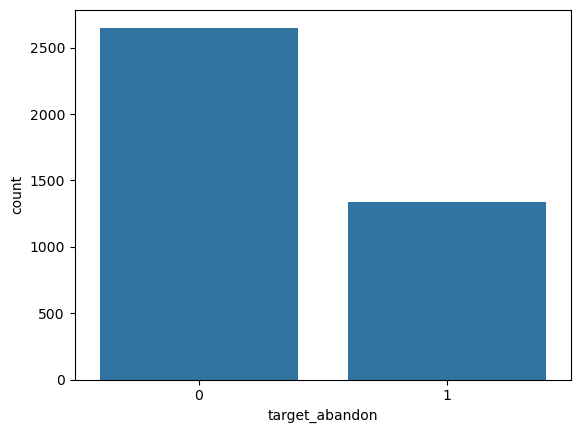

In [159]:
windows_with_ga3 = windows_with_ga2.copy()

# New abandon rate?
print(f"New abandonment rate is {windows_with_ga3['target_abandon'].mean():.4f}")

sns.countplot(data=windows_with_ga3, x='target_abandon')
plt.show()

In [160]:
windows_with_ga3.columns.isna().sum()

0

In [161]:
# Split the data
x = windows_with_ga3.drop(columns=['target_abandon'])
y = windows_with_ga3['target_abandon']

x = x.replace({pd.NA: np.nan})

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=12345,
    stratify=y  # keeps same balance of 0/1 in train and test
)



## Logistic model

In [162]:
# ===== 1) Convert time-like columns to human units (hours/days) =====
# Work on copies to avoid SettingWithCopy warnings
x_train = x_train.copy()
x_test  = x_test.copy()

# Timedelta -> HOURS
td_cols = x_train.select_dtypes(include=['timedelta64[ns]']).columns
for c in td_cols:
    x_train[c] = pd.to_timedelta(x_train[c], errors='coerce').dt.total_seconds() / 3600.0
    x_test[c]  = pd.to_timedelta(x_test[c],  errors='coerce').dt.total_seconds() / 3600.0

# Datetime -> DAYS since an anchor (min train date per column)
dt_cols = x_train.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
for c in dt_cols:
    tr = pd.to_datetime(x_train[c], errors='coerce')
    anchor = tr.min()
    x_train[c] = (pd.to_datetime(x_train[c], errors='coerce') - anchor).dt.total_seconds() / 86400.0
    x_test[c]  = (pd.to_datetime(x_test[c],  errors='coerce') - anchor).dt.total_seconds() / 86400.0

# ===== 2) Build simple pipeline (no standardization) =====
num_cols = x_train.select_dtypes(include=[np.number]).columns
cat_cols = x_train.select_dtypes(include=['object','category','bool']).columns

pipeline = Pipeline(steps=[
    ("prep", ColumnTransformer(transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore", drop="first"))
        ]), cat_cols),
    ])),
    # C > 1 reduces regularization -> easier-to-see coefficients
    ("clf", LogisticRegression(max_iter=1000, solver="liblinear", C=10.0))
])

# ===== 3) Fit & evaluate =====
pipeline.fit(x_train, y_train)

y_pred  = pipeline.predict(x_test)
y_proba = pipeline.predict_proba(x_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))



Test Accuracy: 0.6654135338345865
Test AUC: 0.516465999421627
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       531
           1       0.00      0.00      0.00       267

    accuracy                           0.67       798
   macro avg       0.33      0.50      0.40       798
weighted avg       0.44      0.67      0.53       798



/opt/anaconda3/envs/msba/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/msba/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/msba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/msba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted 

In [163]:
# ===== 4) Coefficients + Odds Ratios (interpretable) =====
pre = pipeline.named_steps["prep"]
clf = pipeline.named_steps["clf"]

# Feature names from ColumnTransformer (sklearn >= 1.0)
try:
    feature_names = pre.get_feature_names_out()
except AttributeError:
    # Fallback for older sklearn
    from sklearn.utils._metadata_requests import _safe_get_feature_names_out
    feature_names = _safe_get_feature_names_out(pre, input_features=x_train.columns)

coefs = clf.coef_[0]

coef_table = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
})
coef_table["odds_ratio"] = np.exp(coef_table["coef"])             # per +1 unit
coef_table["odds_ratio_per_10"] = np.exp(10 * coef_table["coef"]) # per +10 units (helpful for time features)
coef_table["abs_coef"] = coef_table["coef"].abs()

# Sort by influence
coef_table = coef_table.sort_values("abs_coef", ascending=False)

# Pretty display
with pd.option_context('display.float_format', '{:.8f}'.format,
                       'display.max_rows', None,
                       'display.max_colwidth', 120):
    display(coef_table.head(30))



,feature,coef,odds_ratio,odds_ratio_per_10,abs_coef
0,num__CUSTOMER_ID,-0.00000000,1.00000000,0.99999999,0.00000000
10,num__duration_min_max_event_minutes,-0.00000000,1.00000000,1.00000000,0.00000000
9,num__last_event_time,-0.00000000,1.00000000,1.00000000,0.00000000
8,num__first_event_time,-0.00000000,1.00000000,1.00000000,0.00000000
2,num__WINDOW_END_LOCAL,-0.00000000,1.00000000,1.00000000,0.00000000
3,num__WINDOW_END_LOCAL_event_cutoff,-0.00000000,1.00000000,1.00000000,0.00000000
1,num__WINDOW_START_LOCAL,-0.00000000,1.00000000,1.00000000,0.00000000
7,num__ORDER_CREATED_DATE_LOCAL,-0.00000000,1.00000000,1.00000000,0.00000000
4,num__WINDOW_FREQUENCY,-0.00000000,1.00000000,1.00000000,0.00000000
11,num__mode_event_day,-0.00000000,1.00000000,1.00000000,0.00000000
